In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib as jl
import cebra.datasets
from cebra import CEBRA

In [2]:
from nlb_tools.nwb_interface import NWBDataset
dataset = NWBDataset("./000128/sub-Jenkins/", "*train", split_heldout=False) 
### always 3 lines of warning popout; need around 20s

/home/marmoset/miniconda3/envs/cebra/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  return func(args[0], **pargs)
/home/marmoset/miniconda3/envs/cebra/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.6.0-alpha is already loaded.
  return func(args[0], **pargs)
/home/marmoset/miniconda3/envs/cebra/lib/python3.8/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  return func(args[0], **pargs)


In [3]:
#### Bin 1ms resolution into X ms and Smooth spikes with X ms std Gaussian kernel; need around 20s
bin_size = 5
dataset.resample(bin_size)
dataset.smooth_spk(50, overwrite=True, name='smth_50') ## 50ms used by NLB21.ipynb and Gallego2020
# display(dataset.data.head()) ## 5 rows × 332=8+162+162 neurons(when keep both raw&smoothed spikes)
# print(dataset.trial_info) ### [2295 rows=trials x 18 columns]
# print(dataset.data['spikes']) ### 5ms bin>>>[1390461 rows x 182 columns=neurons]
# print(dataset.data) ## [1390461 rows x 190 columns]; extra 8 are cursor_pos/2+eye_pos/2+hand_pos/2+hand_vel/2

In [4]:
neural_all = dataset.data['spikes'] 
hand_xy = dataset.data['hand_pos'] 
hand_vel = dataset.data['hand_vel'] 
move_onset_time = dataset.trial_info['move_onset_time']
trial_type=dataset.trial_info['trial_type'] ## maze configuration that was used for the trial---36
#### 0=1-target no-barrier, 1=1-target with barriers, 2=3-target with barriers
trial_version=dataset.trial_info['trial_version'] 
active_target = dataset.trial_info['active_target'] ## (2295trials for MC_maze,)
target_pos_raw = dataset.trial_info['target_pos']  ## (2295,); each line has >=1 XY locations

dur = int(500/bin_size)
    
import pandas as pd

trials = pd.DataFrame()
neural_all_trials = pd.DataFrame()
for i, onset_time in enumerate(move_onset_time): ## loop through 0 to 2294 (i=0:2294)
    # Define the time range
    
    start_time = onset_time - pd.Timedelta(milliseconds = 50) ## (2295,)
    end_time = onset_time + pd.Timedelta(milliseconds = 450) ## (2295,)
    
    filtered_data = hand_xy.loc[start_time:end_time].copy()  # Use copy() here to avoid SettingWithCopyWarning
    filtered_data['x_norm'] = filtered_data['x']-filtered_data['x'][0]
    filtered_data['y_norm'] = filtered_data['y']-filtered_data['y'][0]
    
    filtered_data['hand_vel_x'] = hand_vel['x'].loc[start_time:end_time].copy()
    filtered_data['hand_vel_y'] = hand_vel['y'].loc[start_time:end_time].copy()
    
    filtered_data['trial_type'] = trial_type.iloc[i]  # Using iloc to match index
    filtered_data['trial_version'] = trial_version.iloc[i]  # Using iloc to match index
    
    T_xy = target_pos_raw[:][i][active_target[i]]
    filtered_data['target_x'] = T_xy[0]
    filtered_data['target_y'] = T_xy[1]
    angle_target = np.arctan2(T_xy[1], T_xy[0]) * (180 / np.pi)
    angle_target_adjusted = np.where(angle_target < 0, angle_target + 360, angle_target)
    filtered_data['angle_target_final'] = angle_target_adjusted
    filtered_data['angle_target_final_int'] = angle_target_adjusted.astype(int)
    
    
    neural_1trial = neural_all.loc[start_time:end_time].copy() ### (100bin, 182neurons)
    neural_all_trials = pd.concat([neural_all_trials, neural_1trial.iloc[0:dur, :]])
    
    trials = pd.concat([trials, filtered_data.iloc[0:dur, :]]) ## only use 25 or 50 values

    ###***very useful for checking assignment***###
#     print('i='+str(i)+' trails_shape='+str(trials.shape)+' duration='+str(end_time-start_time))
#     if filtered_data.shape[0]==51:
#         print(start_time)
#         print(end_time)
    ###***very useful for checking assignment***###
# Optionally, reset the index if needed
trials.reset_index(inplace=True)

# print('trials=', trials) ### [229500=2295trials*100bin x 12 columns]
# print('neural_all_trials=', neural_all_trials)  ### [229500=2295trials*100bin x 182neurons]

<IPython.core.display.Javascript object>


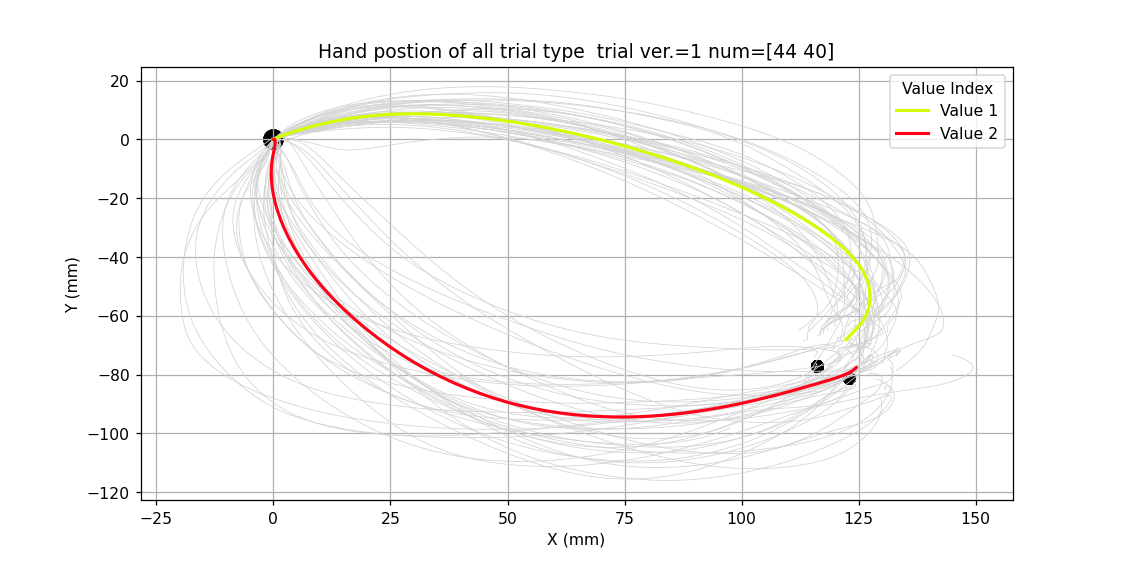

number of trials in this type= 44
x=116 y=-77 target angle=326.4240672855921
Num_tt= 44
t_type= 34
number of trials in this type= 40
x=123 y=-81 target angle=326.633634564801
Num_tt= 40
t_type= 18
c_num=1
c_num=2


In [76]:
# full_types = [1,2,3,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25,26,28,29,30,31,32,33,34,35,36,37,38,39]

# full_types = [1,8,19, 13, 37] ## top-right 37down-22down-29down-22-34
# full_types = [29, 35] ## top 88-88
# full_types = [17, 26, 9, 31, 38] ## top-left 133-143-146-148down-168
# full_types = [30, 3, 11, 20] ## left 178-182-183-185
# full_types = [6,16,36,  24,22] ## bottom-left 213down-215down-215down-216-226
# full_types = [10] ## bottom
# full_types = [34,15,2, 33,28,12,18,39] ## bottom-right 326-328-328-327down-333down-337down-326down-347down

### Four distinct combined curves ###  Unnecessary, could be replaced by other two plots
# full_types = [29,35, 3,11, 16,36, 15,2] # top-left-bottomleft-bottomright
# t_version = 1

###### Four or Three curve-straight pairs ######
# full_types = [13, 38, 6, 18] ## 6 or 16maybe better
# full_types = [13, 38, 18]
# type_name = 'Type: curve-straight'
# t_version = 0

###### Three up-down curve pair ######
## [37,1] ## top-right [31,38] ## top-left [34,18] ## bottom-right
# full_types = [37,1, 31,38, 34,18]
# type_name = 'Type: curve-up-down'
# t_version = 1 ## select>=1

full_types = [34,18]
type_name = 'Type: curve-up-down'
t_version = 1 ## select>=1

fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(111)
ax.scatter(0, 0, s=150, c='black')
trace_x_mean_all = np.empty((len(full_types), dur))
trace_y_mean_all = np.empty((len(full_types), dur))
Num_tt_all = np.zeros([len(full_types),], dtype=int)
t = 0
for t_type in full_types:
    filtered_indices = trials.index[(trials['trial_type'] == t_type) & (trials['trial_version'] >= t_version)]
    Num_tt = int(len(filtered_indices)/dur)
    print('number of trials in this type=', str(Num_tt))
    if filtered_indices.size == 0:
        print('empty')
    else: 
        print('x='+str(trials['target_x'][filtered_indices[0]])+
              ' y='+str(trials['target_y'][filtered_indices[0]])+
             ' target angle='+str(trials['angle_target_final'][filtered_indices[0]])) 
    Num_tt_all[t] = Num_tt
    trace_x_values = np.empty((Num_tt, dur))
    trace_y_values = np.empty((Num_tt, dur))
    print('Num_tt=', Num_tt)
    for i in range(Num_tt):
        
        idx = filtered_indices[dur*i:dur*(i+1)]
        trace_x = trials['x_norm'][idx] ## (dur,) positions minus the starting points
        trace_y = trials['y_norm'][idx]
        ax.plot(trace_x, trace_y, color='lightgrey', linewidth=0.5)
        trace_x_values[i] = trace_x ## (dur, )
        trace_y_values[i] = trace_y
        ax.scatter(trials['target_x'][idx], trials['target_y'][idx], s=50, c='black')

    trace_x_mean = np.mean(trace_x_values, axis=0)
    trace_y_mean = np.mean(trace_y_values, axis=0)
    print('t_type=', t_type)
    trace_x_mean_all[t] = trace_x_mean
    trace_y_mean_all[t] = trace_y_mean
    t = t + 1

c_num = 0
t = 0
colors = plt.cm.hsv(np.linspace(0.2, 1, len(full_types))) ## start from "0" will mix the color at 0&1
for t_type in full_types:
    if abs(np.sum(trace_x_mean_all[t,:]))>0:   
        c_num=c_num+1
        print('c_num='+str(c_num))
        ax.plot(trace_x_mean_all[t,:], trace_y_mean_all[t,:], linewidth=2, 
            color=colors[c_num-1], label=f'Value {c_num}')
        t = t + 1
           
ax.legend(title='Value Index')

plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.title('Hand postion of all trial type '+' trial ver.='+str(t_version)+' num='+str(Num_tt_all))
# plt.scatter(x_values, y_values) ### active targets
plt.scatter(0, 0, s=150, c='black')
plt.grid(True)
# plt.show()

<IPython.core.display.Javascript object>


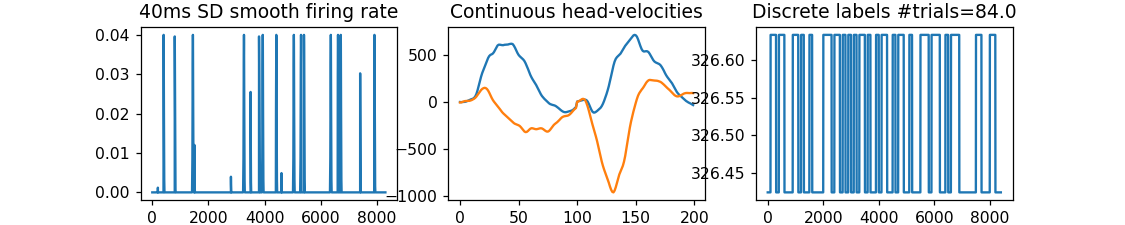

Text(0.5, 1.0, 'Discrete labels #trials=84.0')

In [77]:
model_indices = trials.index[(trials['trial_type'].isin(full_types)) & (trials['trial_version'] >= t_version)]

neural = neural_all_trials.iloc[model_indices, :].to_numpy() 

con_index_x = trials['hand_vel_x'][model_indices].values 
con_index_y = trials['hand_vel_y'][model_indices].values
discrete_index = trials['angle_target_final'][model_indices].values
discrete_index_bin = discrete_index/10 
discrete_index_bin = 10*np.floor(discrete_index_bin)
version_index = trials['trial_version'][model_indices].values
continuous_index = np.column_stack((con_index_x, con_index_y, discrete_index)) 
# continuous_index = np.column_stack((con_index_x, con_index_y, discrete_index_bin)) ## combine motion types

fig = plt.figure(figsize=(10, 2))
plt.subplot(131)
plt.plot(neural[:, 25][dur*1:]) ## randomly selected neuron
plt.title('40ms SD smooth firing rate')
plt.subplot(132)
plt.plot(continuous_index[:, 0][:dur*2])
plt.plot(continuous_index[:, 1][:dur*2]) ## yellow
plt.title('Continuous head-velocities')
plt.subplot(133)
plt.plot(continuous_index[:, 2])
plt.title('Discrete labels #trials='+str(len(discrete_index)/dur))

In [78]:
### 
N_trial = int(continuous_index.shape[0]/dur)
train_trial = int(N_trial*0.8)
test_trial = N_trial-train_trial
def split_data(neural, continuous_index, version_index, train_trial): 
    split_idx = train_trial*dur ## 40bin per trial
    neural_train = neural[:split_idx]
    neural_test = neural[split_idx:]
    continuous_index_train = continuous_index[:split_idx]
    continuous_index_test = continuous_index[split_idx:]
    version_index_train = version_index[:split_idx]
    version_index_test = version_index[split_idx:]
    return neural_train,neural_test,continuous_index_train,continuous_index_test,\
version_index_train,version_index_test

### (28000=56*600, 172neurons) (8000=16*500, 172)      (28000, 3) (8000, 3)
neural_train, neural_test, continuous_index_train, continuous_index_test, \
version_index_train,version_index_test = split_data(neural, continuous_index, version_index, train_trial)

target_angle_train = continuous_index_train[:, 2].copy()
continuous_index_train[:, 2] = 0
target_angle_test = continuous_index_test[:, 2].copy()
continuous_index_test[:, 2] = 0

print('train trial='+str(train_trial)+' test trial='+str(test_trial))
print('continuous_index_train=', continuous_index_train[:5])
print('neural=', neural[0:5, 0:5]) ##(8360bin, 63neurons).
print('neural_train=',neural_train.shape,'neural_test=',neural_test.shape,
      'continuous_index_train=',continuous_index_train.shape,'continuous_index_test=',continuous_index_test.shape)

train trial=67 test trial=17
continuous_index_train= [[-1.34445783 -5.86041875  0.        ]
 [-2.54263576 -5.48516577  0.        ]
 [-2.00510491 -1.19236607  0.        ]
 [-0.46704631  4.19016248  0.        ]
 [ 0.38127819  7.94799402  0.        ]]
neural= [[0.         0.         0.         0.         0.03019493]
 [0.         0.         0.         0.         0.03238431]
 [0.         0.         0.         0.         0.03438684]
 [0.         0.         0.         0.         0.03614989]
 [0.         0.         0.         0.         0.0376252 ]]
neural_train= (6700, 182) neural_test= (1700, 182) continuous_index_train= (6700, 3) continuous_index_test= (1700, 3)


In [80]:
iterations = 5000
lr = 1e-4
output_dimension = 3
cebra_veldir_model = CEBRA(model_architecture='offset1-model',
                        batch_size=512,
                        learning_rate = lr,
                        temperature = 1,
                        output_dimension = output_dimension ,
                        max_iterations=iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=1)
cebra_veldir_model.fit(neural_train, continuous_index_train) ## (28000, 162) and (28000, 3)

cebra_veldir_train = cebra_veldir_model.transform(neural_train) ## get(28000, 3embed-dim)
cebra_veldir_test  = cebra_veldir_model.transform(neural_test)  ## get(8000, 3embed-dim)

pos: -0.9540 neg:  6.4817 total:  5.5277 temperature:  1.0000: 100%|█| 5000/5000


<IPython.core.display.Javascript object>


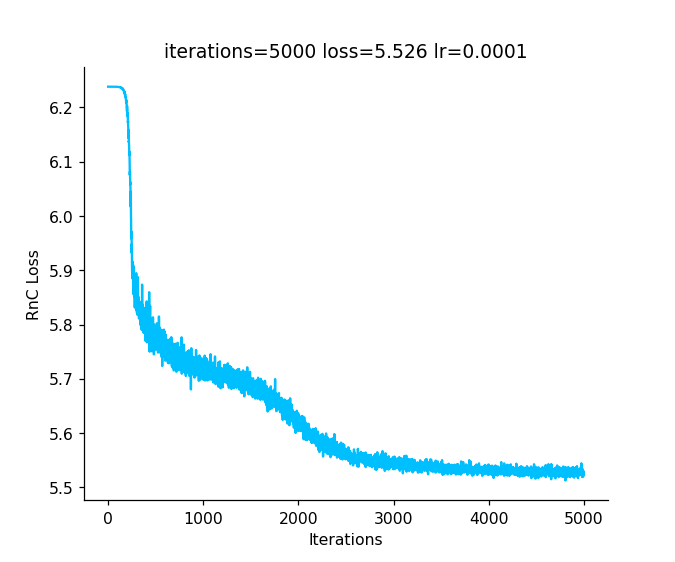

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [81]:
### display the loss during model training process
import os
directory = "./data/"

fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)
train_loss = cebra_veldir_model.state_dict_['loss']
train_loss_stable = train_loss[-10:].numpy()
train_loss_stable = round(np.mean(train_loss_stable), 3)
ax.plot(train_loss, c='deepskyblue') ## label = 'continuous+discrete index'

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('RnC Loss')
plt.title('iterations='+str(iterations)+' loss='+str(train_loss_stable)+' lr='+str(lr))
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False )
plt.show()
filename = type_name+'='+str(full_types)+"_training loss_"+str(iterations)+"itr_lr"+\
    str(lr)+'_='+str(train_loss_stable)+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)

<IPython.core.display.Javascript object>


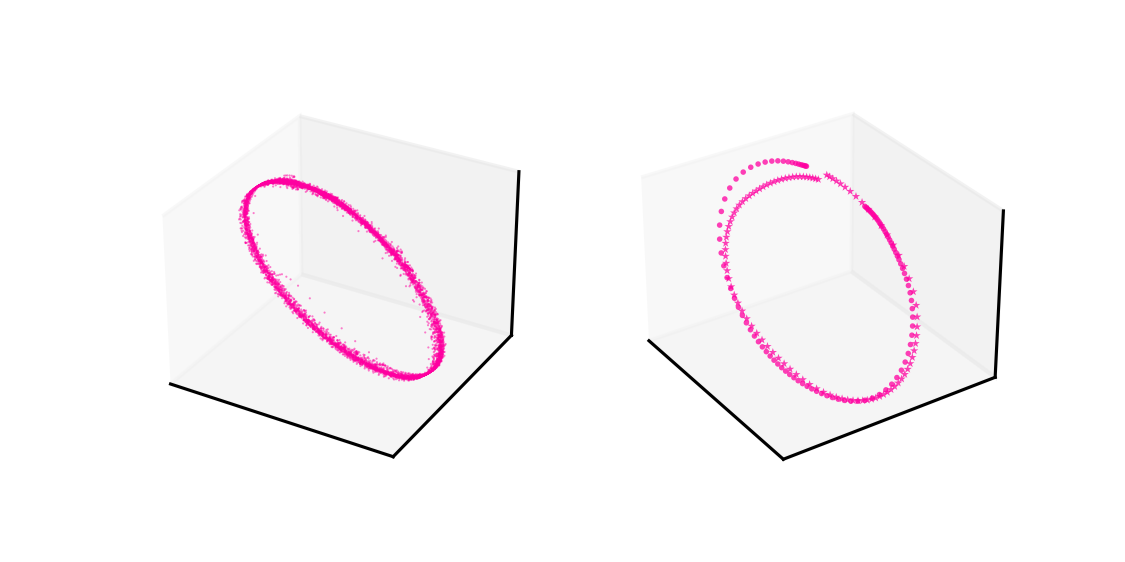

In [82]:
######****** used for one pair or two pairs of up-down curved hand motions
idx1, idx2, idx3 = 0, 1, 2
%matplotlib notebook
dur = 100
N_label = len(np.unique(discrete_index)) ## (28800,)

fig = plt.figure(figsize=(4, 2), dpi=250)
ax = plt.subplot(121, projection = '3d')
x = ax.scatter(cebra_veldir_train[:, idx1],
               cebra_veldir_train[:, idx2],
               cebra_veldir_train[:, idx3],
               color=plt.cm.hsv(1 / 360 * target_angle_train),
               edgecolors='none',
               alpha=0.5,
               s=0.3)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

plot_dur = 100
ax = plt.subplot(122, projection = '3d')
marker_stock={'^', '*'}

angle_1st = np.unique(target_angle_train)[0]
direction_trial = target_angle_train == angle_1st
trial_raw = cebra_veldir_train[direction_trial, :]    
trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
ax.scatter(trial_avg[:plot_dur, idx1],
           trial_avg[:plot_dur, idx2],
           trial_avg[:plot_dur, idx3],
           marker='o',
           color=plt.cm.hsv(1 / 360 * angle_1st),
           edgecolors='none',
           alpha=0.75,
           s=2)
angle_2nd = np.unique(target_angle_train)[1]
direction_trial = target_angle_train == angle_2nd
trial_raw = cebra_veldir_train[direction_trial, :] 
trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
ax.scatter(trial_avg[:plot_dur, idx1],
           trial_avg[:plot_dur, idx2],
           trial_avg[:plot_dur, idx3],
           marker='*',
           color=plt.cm.hsv(1 / 360 * angle_2nd),
           edgecolors='none',
           alpha=0.75,
           s=5)
if len(np.unique(target_angle_train))>2:
    angle_3rd = np.unique(target_angle_train)[2]
    direction_trial = target_angle_train == angle_3rd
    trial_raw = cebra_veldir_train[direction_trial, :]    
    trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
               marker='o',color=plt.cm.hsv(1 / 360 * angle_3rd),edgecolors='none',alpha=0.75,s=2)
    angle_4th = np.unique(target_angle_train)[3]
    direction_trial = target_angle_train == angle_4th
    trial_raw = cebra_veldir_train[direction_trial, :]    
    trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
               marker='*',color=plt.cm.hsv(1 / 360 * angle_4th),edgecolors='none',alpha=0.75,s=5)
if len(np.unique(target_angle_train))>4:
    angle_5th = np.unique(target_angle_train)[4]
    direction_trial = target_angle_train == angle_5th
    trial_raw = cebra_veldir_train[direction_trial, :]    
    trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
               marker='o',color=plt.cm.hsv(1 / 360 * angle_5th),edgecolors='none',alpha=0.75,s=2)
    angle_6th = np.unique(target_angle_train)[5]
    direction_trial = target_angle_train == angle_6th
    trial_raw = cebra_veldir_train[direction_trial, :]    
    trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)
    ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
               marker='*',color=plt.cm.hsv(1 / 360 * angle_6th),edgecolors='none',alpha=0.75,s=5)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()

filename = type_name+'='+str(full_types)+"_Embedding_"+str(iterations)+"itr_lr"+str(lr)+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)

N_label= 1


<IPython.core.display.Javascript object>


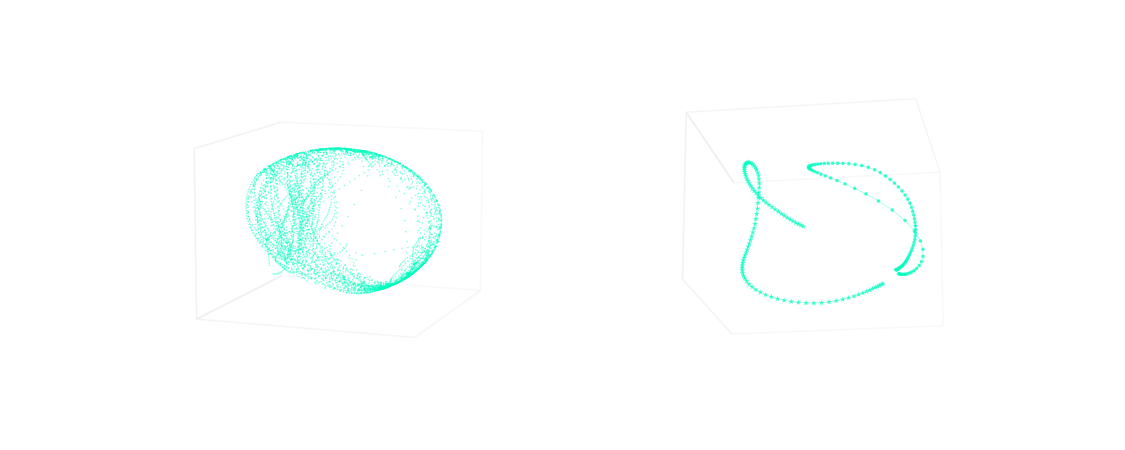

/tmp/ipykernel_7459/4185272278.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  x = ax.scatter(cebra_veldir_train[:, idx1],cebra_veldir_train[:, idx2],cebra_veldir_train[:, idx3],norm=norm,
/tmp/ipykernel_7459/4185272278.py:22: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
/tmp/ipykernel_7459/4185272278.py:23: MatplotlibDeprecationWarning: The w_yaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use yaxis instead.
  ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_7459/4185272278.py:24: MatplotlibDeprecationWarning: The w_zaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use zaxis instead.
  ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
/tmp/ipykernel_7459/4185272278.py:65: MatplotlibDeprecationWarning: The w_xa

exist angle i=168.51101210796958
exist angle i=168.51101210796958


In [42]:
######****** used for two versions: one is straight(v=0) and two are curved(v=1&2)
%matplotlib notebook
dur = 100
N_label = len(np.unique(target_angle_train))
print('N_label=', N_label)
idx1, idx2, idx3 = 0, 1, 2

fig = plt.figure(figsize=(10, 4))
ax = plt.subplot(121, projection = '3d')
norm = plt.Normalize(vmin=0, vmax=1)
x = ax.scatter(cebra_veldir_train[:, idx1],cebra_veldir_train[:, idx2],cebra_veldir_train[:, idx3],norm=norm,
               color=plt.cm.hsv(1 / 360 * target_angle_train),edgecolors='none',alpha=0.5,s=1)

ax.set_facecolor('white')  # Set the background color to white
ax.grid(False)             # Remove the grid
ax.xaxis.pane.fill = False # Remove the background panes
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=10, azim=20)  # Adjust elev and azim for your desired angle   

plot_dur = 100
ax = plt.subplot(122, projection = '3d')
for i in np.unique(target_angle_train):  ###### version 0
    version_trial = version_index_train ==0
    direction_trial = target_angle_train == i
    trial_raw = cebra_veldir_train[version_trial & direction_trial, :] ### (Xtrials*100bin, 3emb)
    if trial_raw.size == 0:
        print('empty angle i='+str(i))
    else:
        print('exist angle i='+str(i))
        trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)## average over trials>(100bin,3emb)
        ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
                   marker='o',color=plt.cm.hsv(0.00+1 / 360 * i),edgecolors='none',alpha=0.75,s=5)
        ax.plot(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
            color=plt.cm.hsv(1 / 360 * i),linewidth=0.25,alpha=0.75)
        
for i in np.unique(target_angle_train):  ###### version 1&2
    version_trial = version_index_train >0
    direction_trial = target_angle_train == i
    trial_raw = cebra_veldir_train[version_trial & direction_trial, :] ### (Xtrials*100bin, 3emb)
    if trial_raw.size == 0:
        print('empty angle i='+str(i))
    else:
        print('exist angle i='+str(i))
        trial_avg = trial_raw.reshape(-1,dur,output_dimension).mean(axis=0)## average over trials>(100bin,3emb)
        ax.scatter(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
                   marker='*',color=plt.cm.hsv(1 / 360 * i),edgecolors='none',alpha=0.75,s=15)
        ax.plot(trial_avg[:plot_dur, idx1],trial_avg[:plot_dur, idx2],trial_avg[:plot_dur, idx3],
            color=plt.cm.hsv(1 / 360 * i),linewidth=0.25,alpha=0.75)

ax.set_facecolor('white')  # Set the background color to white
ax.grid(False)             # Remove the grid
ax.xaxis.pane.fill = False # Remove the background panes
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) # Remove the axis lines
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.view_init(elev=10, azim=20)  # Adjust elev and azim for your desired angle        
        
plt.show()
filename = type_name+'='+str(full_types)+"_Embedding_"+str(iterations)+"itr_lr"+str(lr)+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)

In [83]:
filename = type_name+'='+str(full_types)+"_parameters_"+str(iterations)+"itr_lr"+str(lr)+".npz"
file_save = os.path.join(directory, filename)

np.savez(file_save,
         train_loss_stable=train_loss,
         cebra_veldir_train=cebra_veldir_train,
         cebra_veldir_test=cebra_veldir_test,
         continuous_index_train=continuous_index_train,
         continuous_index_test=continuous_index_test,
         target_angle_train=target_angle_train,
         target_angle_test=target_angle_test,
         version_index_train=version_index_train,
         version_index_test=version_index_test)

<IPython.core.display.Javascript object>


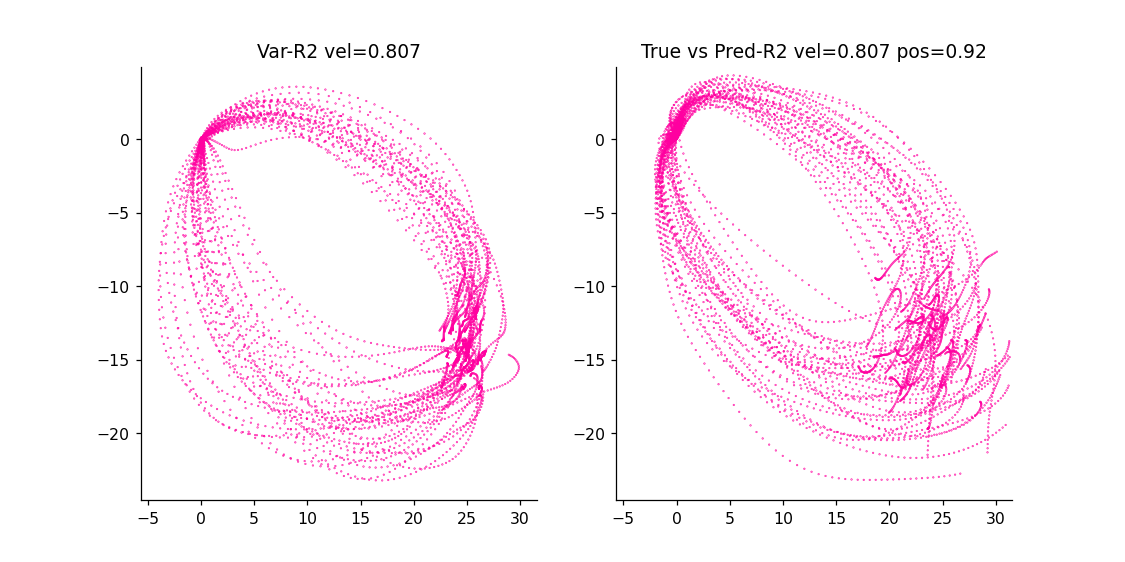

In [84]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics

velocity_reshaped=continuous_index_train[:,0:2].reshape(train_trial,dur,2) ##(Xtrials*100bin,2)to(Xtrials,100bin,2)
locations = np.cumsum(velocity_reshaped/1000, axis=1) ## (Xtrials,100bin,2velocity>>location)
truth_XY = locations.reshape(train_trial*dur, 2) ## (Xtrials*100bin, 2=XY position)
truth_target = target_angle_train ## (Xtrials*100bin,) unique values are [0, 1, 2, 3, 4, 5, 6, 7]

X = cebra_veldir_train
y = continuous_index_train[:, 0:2]
reg = LinearRegression().fit(X, y) ### n_jobs = 8 >>> unnecessary
pred_vel = reg.predict(X) 
velocity_reshaped = pred_vel.reshape(train_trial, dur, 2)
locations = np.cumsum(velocity_reshaped/1000, axis=1)
pred_XY = locations.reshape(train_trial*dur, 2) ## (dur*number of trials, 2=XY position)

posi_r2 = sklearn.metrics.r2_score(truth_XY, pred_XY) ### proportion of total variation explained by model
vel_r2 = sklearn.metrics.r2_score(continuous_index_train[:, 0:2], pred_vel)
 ### same to "vel_r2" but don't need 3 steps "fit(X,Y)>>Z=predict(X)>>score(X,Z)", just "score(X,Y)"

fig = plt.figure(figsize=(10, 5))

ax1 = plt.subplot(121)
trial_version_train = version_index_train ==0
norm = plt.Normalize(vmin=0, vmax=1)
ax1.scatter(truth_XY[trial_version_train, 0], truth_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(0.05+1/360*truth_target[trial_version_train]), s=0.5)
trial_version_train = version_index_train >0
ax1.scatter(truth_XY[trial_version_train, 0], truth_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_train]), s=0.5)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
xlims = ax1.get_xlim()
ylims = ax1.get_ylim()
plt.title('Var-R2 vel='+str(round(reg.score(X, y), 3))) ## must be same as "vel_r2"


ax2 = plt.subplot(122)
trial_version_train = version_index_train ==0
ax2.scatter(pred_XY[trial_version_train, 0], pred_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(0.05+1/360*truth_target[trial_version_train]), s=0.5)
trial_version_train = version_index_train >0
ax2.scatter(pred_XY[trial_version_train, 0], pred_XY[trial_version_train, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_train]), s=0.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
plt.title('True vs Pred-R2 vel='+str(round(vel_r2, 3))+' pos='+str(round(posi_r2, 3)))

filename = type_name+'='+str(full_types)+"_Decoding R2 Train_"+str(iterations)+\
        "itr_lr"+str(lr)+'_vel_'+str(round(vel_r2, 3))+'_pos_'+str(round(posi_r2, 3))+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)

<IPython.core.display.Javascript object>


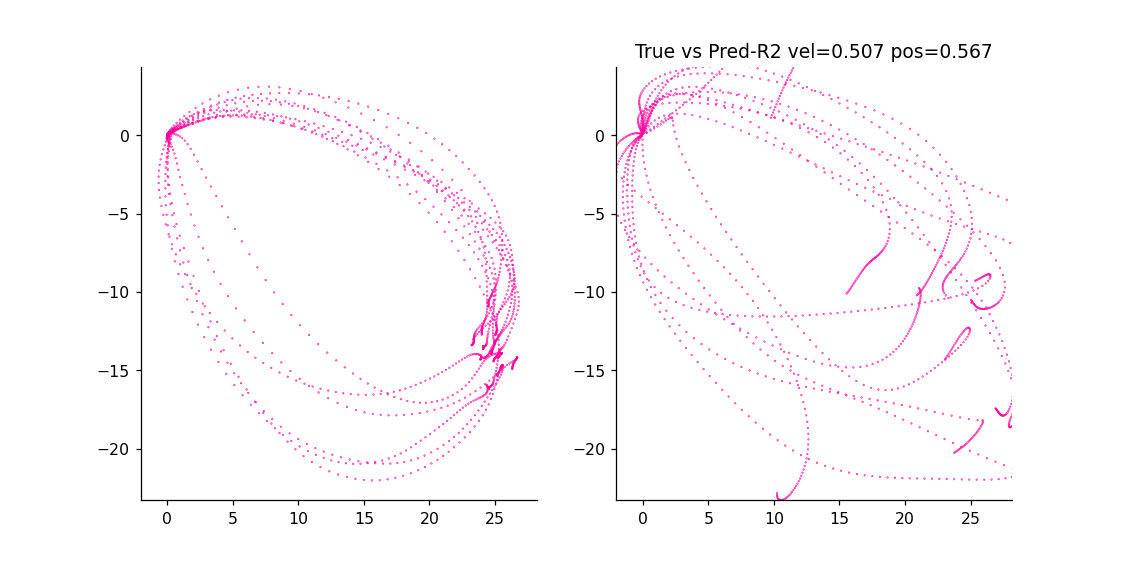

In [85]:
###*** decoding R2 on test trials ***######*** using previous "reg" ***###

fig = plt.figure(figsize=(10, 5))
initial_positions = np.zeros((test_trial, 1, 2))

velocity_reshaped = continuous_index_test[:, 0:2].reshape(test_trial, dur, 2)
locations = np.cumsum(velocity_reshaped, axis=1)/1000
pos_truth = locations.reshape(test_trial*dur, 2)
truth_XY = pos_truth[:, 0:2] 
truth_target = target_angle_test 

pred_vel = reg.predict(cebra_veldir_test)
velocity_reshaped = pred_vel.reshape(test_trial, dur, 2)
locations = np.cumsum(velocity_reshaped, axis=1)/1000
pred_XY = locations.reshape(test_trial*dur, 2)

posi_r2 = sklearn.metrics.r2_score(truth_XY, pred_XY)
vel_r2 = sklearn.metrics.r2_score(continuous_index_test[:, 0:2], pred_vel)

ax1 = plt.subplot(121)
trial_version_test = version_index_test ==0
ax1.scatter(truth_XY[trial_version_test, 0], truth_XY[trial_version_test, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(0.05+1/360*truth_target[trial_version_test]), s=0.5)
trial_version_test = version_index_test >0
ax1.scatter(truth_XY[trial_version_test, 0], truth_XY[trial_version_test, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_test]), s=0.5)
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
xlims = ax1.get_xlim()
ylims = ax1.get_ylim()

ax2 = plt.subplot(122)
trial_version_test = version_index_test ==0
ax2.scatter(pred_XY[trial_version_test, 0], pred_XY[trial_version_test, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(0.05+1/360*truth_target[trial_version_test]), s=0.5)
trial_version_test = version_index_test >0
ax2.scatter(pred_XY[trial_version_test, 0], pred_XY[trial_version_test, 1], alpha=1, marker='.', 
            color=plt.cm.hsv(1/360*truth_target[trial_version_test]), s=0.5)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_xlim(xlims)
ax2.set_ylim(ylims)
plt.title('True vs Pred-R2 vel='+str(round(vel_r2, 3)) + ' pos='+str(round(posi_r2, 3)))

filename = type_name+'='+str(full_types)+"_Decoding R2 Test_"+str(iterations)+\
        "itr_lr"+str(lr)+'_vel_'+str(round(vel_r2, 3))+'_pos_'+str(round(posi_r2, 3))+".pdf"
output_path = os.path.join(directory, filename)
plt.savefig(output_path)